# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192. Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

5) Провел маштабное расследование в данных. Сначала просто обучил lgbm со скором примерно 0.817 и применил на нам всю информацию из семинара про интерпретацию бустингов. Пока что не совсем понятно как это оформиать и как интерпретировать некотрые вещи, но что точно ясно это то, что модель досточно устойчива и надежна, она не реазирует на теневые фичи, а это значит что местами можно делать бред не боясь за последствия. Например сделать полиномиальные фичи - всео со всеми. 

6) Это я и сделал, вмете с новыми фиками добавил количество поисков на последний месяц и неделю. Паралельно с этим убрад один выбрас user_id = 2346229. У человека были абсолютно неадекватные значения. Есть еще большое количество таких людей, но у них значения не такие радикальные и я боюсь что они могут оказаться просто очень активными пользователями, выкидывать их значит лишать себя бесценной информации. После добавления пачуи полиномиальных фичей скор стал 0.8210. Дальше планирую применить кластеризацию на поиске и заказах. Мне кажется очень логичным, что если человек совершал покупки одной категории, то он вероятнее купит еще, чем другой человек с та4ким же числом покупок, но разных категорий. 

7) Кластеризация. Очень долго ей занимался, сейчас подведу итоги всех трех дней. Главная идея такая - модель уже использует агригаты, так что для того чтобы повысить качество нужно использовать какую то иную информацию. Первое что проходит на ум - запросы человека. Банально провести кластеризацию на запросах и потом построить на этих метках новые агрегаты. Но есть проблема, у нас 77кк строк запросов и даже если написать нормальный алгоритм это будет работать 19 часов. Помимо того на сэмпле и понижении размерности через PCA выяснилось, что данные это полосы, крупные классы забивают мелкие и те группируются одной неразделимой кучей в углу, не получается чегото адекватного даже если использовать гауссовскую кластеризациюд или GMM. 300к обьектов обрабатывались несколько минут и я решил сделать кластеризацию полуавтоматически. Я создал столбец 'cluster' и заполнил его -1. Построив кластеризацию на 10_000 обьектах выделил некоторые классы, они ясно выделаются, например 20-30 обьектов с словом "вода" в названии, и заполнил их метки руками. Потом снова построил кластеризацию на оставшихся. Леноточная структура осталась, но обьекты былит уже другими. за каждую такую итерацию отсеивалось от 3кк до 10кк обьектов. Итого у меня определилось 18 кластеров - напитки, питомцы, мясо и многое другое. В итоге еще осталось 23кк обьектов, но там очень сложно выделить группы. В принципе я могу свести их до 10кк, но вопрос есть ли в этом смысл. После таких не простых манипуляций мы получаем метки, но это просто инструмент. То что реально даст прирост качества это агрегаты. Не просто было придумать их и не все оказались удачными. Я добавил последний доминирующий кластер, концентрация интересов, переключения между кластерами, стабильность кластеров, время в основном кластере, среднее время между сменами кластеров, средняя длина запроса, разница длины запросов. В итоге скор получился 0.8221. P.S. на самом деле тут значение спокойно колеблется на +- 0.0002
Мне не кажется, что возможно сделать кластеризацию привычным образом, потому что методы класического мл не способны определить, что между словами 'вода' и 'кола' есть что то общее, ну а я ручной кластеризацией относил их к напиткам. Подробнее в разделе кластеризации. 

8) Итак, начинаем агрегацию через knn, начальный скор без поли фичей и кластеризации по поиску - 0.8208

9) Косле knn скор 0.8209, нет особо смысла это делать при таких условиях, потому что я данных много пропусков. Вернее в тех столбцах, на которых запускал я много пропусков, нужно было попробовать меньшее количество столбцов, но сейчас я хочу в отдельном файле сконцентрораваться на генерации признаков, их трансформации и кодирвоании. P.S. Завтыкал и просто не правильно делал переменную cols. В итоге knn признаки не учитывались при работе модели. Подробнее в разделе кнн. 

10) Решил провести кластеризацию еще и на товарах. На самом деле это относительно не затратное дело - списки слов уже есть, нужно просто пропустить через них датасет, и немного добавить товары, которые не вошли. Генерация признаков аналогичная поиску. В этот же момент раздуплился с knn, добавил их признаки в cols и получил скор 0.8238. 

11) Пробую сделать кросс валидацию, потому что мне жалко отдавать столько данных просто так, но ничего не получается, скор падает до 0.8214 и я оставляю эту идею.
12) Анализирую признаки, оказывается что многие из признаков типа days_ не могут нормально разделить пользователей, если прошло меньше месяца, так что добавляю раздел признаков _30d, где делаю агегаты за последние 30 дней. В них входят как банальные число кликов и добавлений в корзину, так и интересные,по типу частота максимального кластера и число активных дней за этот месяц. 

13) В попытках улучшения пересматриваю записи лекций мл и вспоминаю про ансамбли. Решаю, что хорошая идея попробовать усреднить метки lgb и catboost. Такой подход дает мне 0.8244. Дальше следует много провальных попыток сделать стэккинг, в теории очень эффективный подход, но на практике у меня так и не вышло грамотно организовать работу с ним. Видимо модели получались слишком похожими и скор только падал. 5 попыток это слишком мало, для того чтобы разобраться в такой сложной вещи. Оптюна также не дала прироста скора, бустинг очень бустро начинает переобучатся, так что мне показалось, что намного выгоднее просто руками по подбирать параметры и посмотреть как меняется скор на трейне и валидации.

14) Чтобы побить скор еще дальше решаю делать новые признаки, сразу кучей. В первую очередь это признаки того, в какое время для было совершено действие. Также добавил признаки брендов товаров и признаки характеризующие поисковые запросы. Применяя лгбм и катбуст получил 0.8246. Все фичи этого раздела имеют приписке new_ спереди.

15) Пробить скор не получается, так что я решаю воспользоваться уже сработавшим способом. В кластеризации поиска осталось 23кк не распределенных слов, так что их нужно добить. Довожу количество слов некластеризованых запросов до 6кк, но есть нюанс. В этот раз я делал все по другому, завел функцию, которая принимает словарь, где ключ это метка кластера, а значение это список ключевых слов. Эта функция проиегает по датасету и классифицирует строки. Все что мне оставалось это выводить топ не распределенных слов и коллекции и раскидывать их по категориям. Только вот прироста это не дало, как мне кажется из за того, что я силько аггресивно распределял слова, например в категорию 10 попали все товары, которые явно не продукты и не другое категории, я назвал их товары для дома. Но там много слов для средств отчистки, можно было бы их выделить отдельно. Тоже самое с категорией 19. Мне кажется что добивание кластеризации получилось мусорное и очень трудоемкое. улучшения нет. 

16) Неожиданно для себя выяснил, что не использовал виджеты, хотя это очень важная информация. Сделал агрегаты по ним, банальные, число пользования и частота. Прирост сумашедший, до 0.8260

17) Делаую интересный блендинг, обучаю несколько моделей и каждая из них получает только 85% всех признаков. Pезультаты их работы просто усредняю, скор получается 0.8263

18) Провожу анализ ошибок модели, строю графики, бинаризованые ящики с усами, даже делаю кластеризацию на FN и FP обаектах, но такое ощущение, что дело не в модели а в обьетах. Это просто люди, которые поступают спантанно и такие действия нельзя предсказать, так что и кластеризация не сработает. Хотя идея классная, если мы видим, что обьект теста похож на обьект из FN/FP групп, то можно метку этого обьекта заменить на противоположную. 

19) По какой то странной причине не получается выдать скор выше 0.8260, даже если я едва модифицирую ноутбук, который выдал 0.8263. Сейчас добавил новые признаки, один из них крайне успешный, spending_rate. Он считается как отношение sum_discount_price_order и days_since_first_order. Признак сразу вырвался в топ. 

20) Был какой то странный баг, сейчас перезапустил код и все стало ок. С новыми признаками (те среди которых есть spending_rate) простой  lgb выдает train's auc: 0.770589, valid's auc: 0.765088. Тут у нас отличный скор на валидации и приемлемое переобучение на трейне, самое то для блендинга. Запустил блендинг на 15 моделях с 78 процентами фичей, большенство из них выдали 0.7644+ с хорошим переобучением. Для сравнения, когда я поулчил скор 0.8260 у меня модели на блендинге выдавали примерно train's auc: 0.770049, valid's auc: 0.76356, там я использовал 5 моделей и 85 процентов. Сейчас у меня готов сабмит, но в силу того, что доделывать мне почти нечего(разве что кнн добавить, хз будет ли лучше от этого или хуже, у многих он только мешал) я хочу засабмитить где то за 2-3 часа дл конца, то есть в 18-19 часов, сейчас только 14.



--------------------------------------------

In [5]:
import base64
from IPython.display import Image, display, HTML

def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()

# Конвертируем изображение в base64
days_since_last_order_image = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2\\imgs\\days_since_last_order.jpg")
box_plot_image = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2\\imgs\\box_plot.jpg")
FNFPCluster_image = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2\\imgs\\FNFPCluster.jpg")
clust_1_image = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2\\imgs\\Кластеризация_запросов.jpg")
clust_2_image = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2\\imgs\\Кластеризация_2.jpg")
knn_ex_image = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2\\imgs\\knn_ex.jpg")

In [ ]:
# Считывание данных
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [ ]:
# Таблица дейстий 
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"
    )

In [39]:
# search_aggs
id_ = 4
suf = 'search'

# Кластеры
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # мера разнообразия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # ПЕреключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\305091891.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [ ]:
# Таблица продуктов 
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов - не валидны для бустинга но полезны для генерации
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [ ]:
# действий за последний месяц
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) & 
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

In [42]:
# Виджеты
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= train_end_date) &
        (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
            (pl.col('timestamp').dt.date() <= train_end_date) &
            (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\3802452689.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\3802452689.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [43]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
df_main = df_main.join(widget_aggs, on='user_id', how='left')

df_main = df_main.with_columns([
    pl.col('last_click_time').dt.hour().alias('last_click_hour'),
    pl.col('last_order_time').dt.weekday().alias('last_order_weekday'),
])

df_main = df_main.with_columns([
    (pl.col('last_order_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_order_days'),
    (pl.col('last_favorite_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_favorite_days')
])

df_main = df_main.with_columns([
    (pl.col('main_search_cluster') == pl.col('main_product_cluster')).alias('main_cluster_match'),
    pl.col('top3_search_clusters').list.contains(pl.col('main_product_cluster')).alias('product_cluster_in_search_top3')
])

df_main = df_main.with_columns([
    (pl.col('num_products_order') / pl.col('num_products_click')).alias('click_to_order_rate'),
    (pl.col('num_products_to_cart') / pl.col('num_products_click')).alias('click_to_cart_rate')
]).fill_null(0)

df_main = df_main.with_columns([
    (pl.col('days_since_first_click') > 30).alias('is_long_term_user'),
    (pl.col('days_since_last_click') < 7).alias('is_active_user')
])

df_main = df_main.with_columns([
    (pl.col('sum_discount_price_order') / pl.col('days_since_first_order')).alias('spending_rate')
])

df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

df_pd['main_cluster_match'] = (
    df_pd['main_cluster_match']
    .map({True: 1, False: 0, None: -1, np.nan: -1})
    .astype(int)
)

In [45]:
from local_utils import *
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability', 'widget_3_ratio', 'widget_21_ratio', 'widget_7_ratio', 'widget_12_ratio', 'widget_4_ratio', 'active_days_30d']

df_pd = add_NS_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled (on copy)
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['knn_distance_mean'] = distances.mean(axis=1)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['knn_distance_mean'] = distances.mean(axis=1)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Added 118 KNN features to original dataframe


------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [46]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\2875394979.py:56: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [47]:
id_ = 4
suf = 'search'

val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\3842640472.py:47: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [48]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [49]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\3703428510.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\3703428510.py:25: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [50]:
# виджеты
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1925535333.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1925535333.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [51]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')
test_df_main = test_df_main.join(widget_aggs, on='user_id', how='left')


test_df_main = test_df_main.with_columns([
    pl.col('last_click_time').dt.hour().alias('last_click_hour'),
    pl.col('last_order_time').dt.weekday().alias('last_order_weekday'),
])

test_df_main = test_df_main.with_columns([
    (pl.col('last_order_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_order_days'),
    (pl.col('last_favorite_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_favorite_days')
])

test_df_main = test_df_main.with_columns([
    (pl.col('main_search_cluster') == pl.col('main_product_cluster')).alias('main_cluster_match'),
    pl.col('top3_search_clusters').list.contains(pl.col('main_product_cluster')).alias('product_cluster_in_search_top3')
])

test_df_main = test_df_main.with_columns([
    (pl.col('num_products_order') / pl.col('num_products_click')).alias('click_to_order_rate'),
    (pl.col('num_products_to_cart') / pl.col('num_products_click')).alias('click_to_cart_rate')
]).fill_null(0)

test_df_main = test_df_main.with_columns([
    (pl.col('days_since_first_click') > 30).alias('is_long_term_user'),
    (pl.col('days_since_last_click') < 7).alias('is_active_user')
])

test_df_main = test_df_main.with_columns([
    (pl.col('sum_discount_price_order') / pl.col('days_since_first_order')).alias('spending_rate')
])


test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [52]:
test_df_pd = add_NS_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled (on copy)
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['knn_distance_mean'] = distances.mean(axis=1)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['knn_distance_mean'] = distances.mean(axis=1)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

Added 118 KNN features to original dataframe


In [53]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [54]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [55]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [56]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

df_pd = add_time_pattern_features(df_pd, actions_history, product_info)
df_pd = add_brand_category_features(df_pd, actions_history, product_info) 
df_pd = add_search_features(df_pd, search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1097620067.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1097620067.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1097620067.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\2438321060.py:12: 

In [57]:
test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
test_df_pd = add_brand_category_features(test_df_pd, actions_history, product_info) 
test_df_pd = add_search_features(test_df_pd, search_history)

test_df_pd['main_cluster_match'] = (
    test_df_pd['main_cluster_match']
    .map({True: 1, False: 0, None: -1, np.nan: -1})
    .astype(int)
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1097620067.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1097620067.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\1097620067.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_153576\2438321060.py:12: 

----------------------------

In [58]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

t_lgb_tr, t_lgb_val = get_split(df_pd, val_size=0.35)

t_cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

t_lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',

    'max_depth': 7,

    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

t_lgb_model = train_model_new(t_lgb_tr, t_lgb_val, t_cols, 'target', params=t_lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 421099, number of negative: 797621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.301467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46530
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 240
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345526 -> initscore=-0.638766
[LightGBM] [Info] Start training from score -0.638766
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.766097	valid's au

feature_importance: [ 46  22  40  15  21  40  29  98  45  30  33  87  16  76   9  15  59  25
   8  17  29  26  33  48  64 141  42  88   7   1   8   8  61  87  34   0
  47  35  24  20  25  31  30   1 205 127   8  58  26  48   7  27   5  46
  29  33  29   0  52  31  14  31  46  20  27  21  24  35  54  24   3  36
   3  37  82  31  23  14  20 157  28  18   1  24  38  36 104  42  54   2
  71  17  58  64  55  41  37  21  14  37  50  27  20  32  22  24   5  32
  39  39  10  14   0  27  16  24  71  34   0  25   8  39  23  96   5  38
  35  35   1  51  15  19   0  83  16  55  66   8  27  18  25  36  30  38
  69  71   7  67   0  83  15   3  26  51  60  33   7  81  17  24  25   0
  46  78  36  23 106  27  15  39  47  28  25   0  10  31   5  28  26  31
   0   6  52  27  15  20   0 136  41   0   1   4  20  11  37   9  21  99
  91  59   0 110  37   0  20  50  31   0  49  24  13  59   3  55   0  21
  27  61   6  16  24  12  24  53   7   2  42   0   0   0 108   0  39  25
   0  15  30  36  29   6  19  3

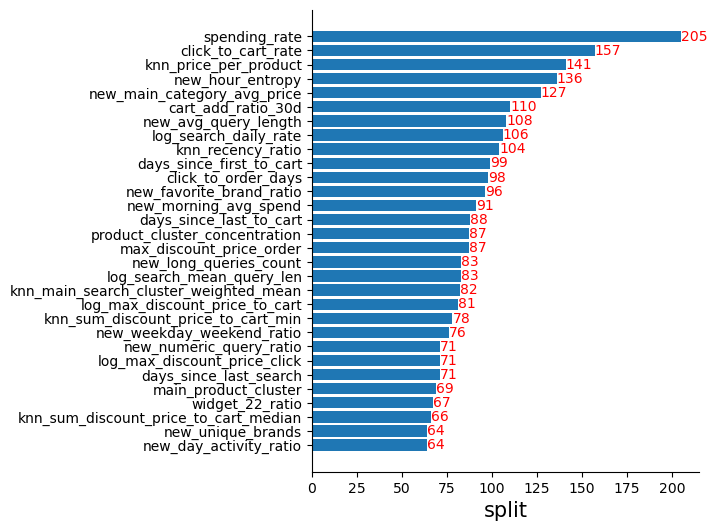

In [59]:
from local_utils import *

print('feature_importance:', t_lgb_model.feature_importances_, '\n')

plot_lgbm_importance(t_lgb_model, t_cols, importance_type='split', top_k=30, sklearn_style=True)

-------------------------------------------

In [60]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]
lgb_tr, lgb_val = get_split(df_pd, val_size=0.37)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 
                                 'last_order_time', 'first_order_time', 
                                 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time',
                                 'top3_search_clusters', 'top3_search_counts', 
                                 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

n_models = 14
feature_frac = 0.78


feature_subsets = []
remaining_features = set(cols.copy())

for i in range(n_models):
    if remaining_features:
        # Берем часть еще неиспользованных фичей
        n_new_features = max(1, int(len(remaining_features) / (n_models - i)))
        new_features = np.random.choice(list(remaining_features), n_new_features, replace=False)
        remaining_features -= set(new_features)
        
        # Добираем случайными фичами до 70%
        n_additional = int(len(cols) * feature_frac) - len(new_features)
        additional_features = np.random.choice(
            [f for f in cols if f not in new_features], 
            n_additional, 
            replace=False
        )
        
        feature_subset = list(new_features) + list(additional_features)
    else:
        # Все фичи уже использованы, просто берем случайные 70%
        feature_subset = np.random.choice(cols, int(len(cols) * feature_frac), replace=False)
    
    feature_subsets.append(feature_subset)

# Обучаем базовые модели и собираем их предсказания
base_models = []
train_predictions = np.zeros((len(lgb_tr), n_models))
val_predictions = np.zeros((len(lgb_val), n_models))

for i, feature_subset in enumerate(feature_subsets):
    print(f"Training base model {i+1} on {len(feature_subset)} features...")
    
    model = train_model_new(
        lgb_tr, 
        lgb_val, 
        feature_subset, 
        'target', 
        params=lgb_params, 
        shadow_features=False, 
        sklearn_style=True
    )
    base_models.append(model)
    
    # предсказания на трейне и валидации
    train_predictions[:, i] = model.predict_proba(lgb_tr[feature_subset])[:, 1]
    val_predictions[:, i] = model.predict_proba(lgb_val[feature_subset])[:, 1]

Training base model 1 on 188 features...
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 408043, number of negative: 773178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36751
[LightGBM] [Info] Number of data points in the train set: 1181221, number of used features: 186
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345442 -> initscore=-0.639137
[LightGBM] [Info] Start training from score -0.639137
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roun

In [61]:
res = []
for i, m in enumerate(base_models):
    feature_subset = feature_subsets[i]
    res.append(m.predict_proba(test_df_pd[feature_subset])[:, 1])

In [62]:
# создаем датасет с предсказаниями
predictions_array = np.array(res).T
res_df = pd.DataFrame(predictions_array, columns=[f'Model_{i+1}' for i in range(len(res))])

# добавляем user_id из исходных данных
res_df['user_id'] = test_df_pd['user_id'].values

res_df['predict'] = res_df[[f'Model_{i+1}' for i in range(len(res))]].mean(axis=1)
res_df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,user_id,predict
0,0.168194,0.179258,0.170866,0.161993,0.171452,0.160290,0.156984,0.174107,0.171100,0.164355,0.168065,0.156833,0.171794,0.171737,1342,0.167645
1,0.685879,0.806179,0.804021,0.765739,0.763751,0.619963,0.734247,0.743576,0.756981,0.790994,0.754916,0.718692,0.740005,0.770675,9852,0.746830
2,0.223255,0.218731,0.219266,0.217127,0.216407,0.219825,0.218080,0.214262,0.219244,0.214982,0.212752,0.223330,0.220770,0.219739,10206,0.218412
3,0.228835,0.231276,0.230540,0.230315,0.231085,0.229501,0.232222,0.226420,0.234059,0.234613,0.231036,0.227679,0.221308,0.228867,11317,0.229840
4,0.573019,0.656638,0.595155,0.610053,0.581333,0.636222,0.641310,0.649476,0.620707,0.681698,0.599140,0.700103,0.638375,0.631242,13289,0.629605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,0.188579,0.196458,0.186733,0.164610,0.184596,0.213468,0.180615,0.186157,0.188811,0.192714,0.199097,0.180838,0.194661,0.205389,11157283,0.190195
2068420,0.038402,0.046484,0.037227,0.055538,0.044277,0.052677,0.057353,0.054177,0.053013,0.053314,0.046101,0.055097,0.060461,0.145760,11160395,0.057135
2068421,0.557306,0.593554,0.548603,0.621297,0.599396,0.568469,0.541556,0.564767,0.572702,0.590186,0.645108,0.580608,0.600469,0.577379,11165052,0.582957
2068422,0.565724,0.547605,0.521090,0.530542,0.511651,0.483871,0.523907,0.492937,0.573684,0.562911,0.483568,0.551582,0.520615,0.539364,11168218,0.529218


------------------------------------------------------------

# Генерация признаков

По моему мнению самый важный этап всей работы, именно тут, при правильном подходе, можно добитьвся выдающегося результата. Самое важное, что я для себя уяснил - нужно стараться воспользоваться абсолютно всей информацией, которая дается в задании. Я же решил, что виджеты не очень важные и просто не использовал их, а когда вспомнил они дали мне огромный прирост(+0.002). Интуиция у генерации признаков такая - данные представлены как тупой лог действий пользователя, в таком формате они не пригодны для бустингов, так что с ними нужно что то делать. Например агрегировать, те для кажого пользователя собирать статистику за периоды. Получается так, что в качестве данных нам дали распределенные по временной шкале действия, а мы их преобразуем в статистики. Ясно, что после такого преобразования часть информации, заключенная в логах, не отобразиться в агрегатах. Так вот смысл генерации признаков в том, чтобы информации терялось как можно меньше. Тут можно действовать по разному. Самый логичный подход это накидать в начале признаков +- от балды, какие нравятся. После этого проанализировать результаты работы модели. Основываясь на них можно понять, в каких местах не хватает признаков, где модель не справляется и что именно стоит добавить. Подробнее об этом рассказывается в разделе интерпретации модели. 

В итоге у меня были сгенерированы такие признаки:

1) Временные паттерны пользователей (все признаки имеют приписке new_ потому что были созданы в период, описаный в дневнике):
    - new_morning_activity_ratio - доля действий пользователя утром.
    - new_day_activity_ratio - доля дневныз действий.
    - new_weekend_activity_ratio - доля действий в выходные.
    - new_hour_entropy - показывает равномерность активности пользователя. 
    - new_weekday_weekend_ratio - отношение активности в будни к активности в выходные.
    - new_morning_avg_spend - средние траты утром.  

2) Особенености взаимодействия с брендами и категориями:
    - new_unique_brands - число уникалных брендов
    - new_favorite_brand_ratio - частота амого популярного бренда
    - new_unique_categories - число уникальных категорий товара
    - new_favorite_category_count - число любимой категории
    - new_main_category_avg_price - средняя цена в любимой категории

3) Особенности поисковых запросов (помимо кластеризации): 
    - new_avg_query_length - среднее число слов в запросе
    - new_numeric_query_ratio - доля запросов содержащих цифры
    - new_long_queries_count - число запросов длиной больше 20

4) Общие признаки:
    - click_to_order_rate - отношение числа заказов в кликам
    - click_to_cart_rate - отношение добавления в корзину к кликам
    - is_long_term_user - первый клик более 30 дней назад
    - is_active_user - были клики последние 7 дней
    - spending_rate  - сумма заказов / дней с первого заказа
    - main_cluster_match  - совпадение основного кластера поиска и покупок
    - product_cluster_in_search_top3  - находится ли основной кластер покупок в топ3 кластеров поиска
    - click_to_order_days  - среднее вермя от клика до заказа
    - click_to_favorite_days  - среднее время от клика до добавление в любимое

5) Анализируя распределение значений на признаказ я пришел к тому, что некоторые из них слишком сжаты и при логорифмировании они становятся лучше разделимые. Логорифмированию были подвергнуты: 

    - max_discount_price_click
    - num_products_favorite
    - sum_discount_price_favorite
    - max_discount_price_favorite
    - num_products_order
    - sum_discount_price_order
    - num_products_to_cart
    - max_discount_price_to_cart
    - num_search
    - unique_search_queries
    - num_search_last_month
    - num_search_last_week
    - search_daily_rate
    - search_cluster_switches
    - search_mean_query_len
    - search_main_cluster_query_len_diff



------------------------

# Интерпретация построенных моделей град. бустинга

Интерпретация - главный этап в генерации признаков. Как я уже сказал, чтобы не тыкать пальцем в небо нужно понять, где признаки справляются, а где нет. 

In [ ]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target, support_col='days_since_last_order', support_log=False)


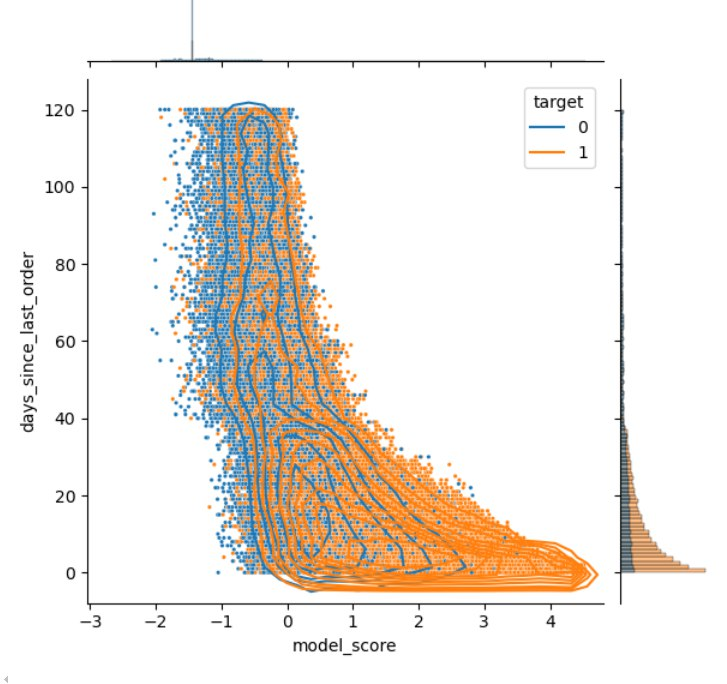

In [6]:
display(Image(url=f"data:image/jpg;base64,{days_since_last_order_image}"))

На примере такого признака видно, что можно провети вертикальную прямую и отделить оранжевые от синих, например на 1-1.5. То есть когда значение признакак до 40 модель хорошо отчает людей. А вот если больше то нет. Значит нужно добавить новые признаки, которые будут работать отдельно для людей, которые заказывали давно.

Еще один пример интерпретации модели это проверка коррелации признака с ошибкой модели.

In [ ]:
from typing import List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator

def feature_error_cor(
    model: BaseEstimator,
    df: pd.DataFrame,
    cols: List[str],
    n: int = 30
) -> None:
    """
    Анализирует ошибки модели и выводит тепловую карту корреляции признаков с величиной ошибки.

    Параметры:
    ----------
    model : sklearn.base.BaseEstimator
        Обученная модель с методом predict_proba().
    df : pandas.DataFrame
        Датафрейм, содержащий признаки и целевую переменную 'target'.
    cols : List[str]
        Список признаков, для которых вычисляется корреляция с ошибкой предсказания.
    n : int, optional (default=30)
        Количество топовых признаков для отображения.

    Возвращяеи:
    -----------
    None
        Функция выводит:
        1) Статистику по ошибочным предсказаниям
        2) Тепловую карту корреляции признаков с величиной ошибки
    """
    # Вероятности
    test_predictions: np.ndarray = model.predict_proba(df[cols])[:, 1]
    
    # Создаем датафрейм с ошибочными предсказаниями
    wrong_predictions: pd.DataFrame = df.assign(
        predicted_prob=test_predictions,
        predicted_class=(test_predictions > 0.5).astype(int)
    ).query(
        "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
    ).copy()
    
    # Вычисляем величину ошибки (разница между предсказанием и таргетом)
    wrong_predictions['error_magnitude']: pd.Series = np.abs(
        wrong_predictions['predicted_prob'] - wrong_predictions['target']
    )

    # Общая статистика по предсказаниям
    print(f"Всего ошибочных предсказаний: {len(wrong_predictions)}")
    print(f"Доля ошибок: {len(wrong_predictions)/len(df):.2%}")

    # Ложно положительные и ложно отрицательные предсказания. 
    fp: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 0]
    fn: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 1]

    print(f"Неверно предсказали 1 (FP): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
    print(f"Неверно предсказали 0 (FN): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")

    # Вычисляем корреляцию признаков с велечиной ошибки. 
    corr_data: pd.DataFrame = wrong_predictions[cols].corrwith(
        wrong_predictions['error_magnitude']
    ).to_frame('correlation')
    
    # Сортируем и выводим n
    corr_data_sorted: pd.DataFrame = corr_data.sort_values(
        'correlation', 
        key=abs, 
        ascending=False
    ).head(n)

    # Строим хитмэп
    plt.figure(figsize=(6, 12))
    sns.heatmap(
        corr_data_sorted,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt='.2f',
        cbar_kws={'orientation': 'horizontal'}
    )
    plt.title('Корреляция признаков с величиной ошибки')
    plt.tight_layout()
    plt.show()

Всего ошибочных предсказаний: 440387
Доля ошибок: 23.49%
Неверно предсказали 1 (FP): 102207 (23.21%)
Неверно предсказали 0 (FN): 338180 (76.79%)


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


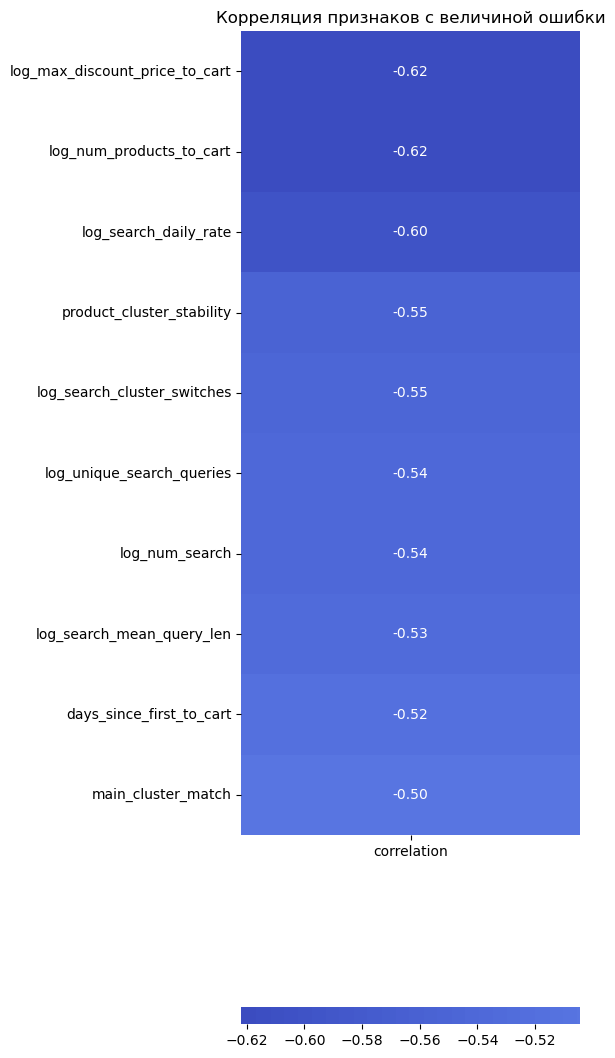

In [ ]:
feature_error_cor(t_lgb_model, df_pd, t_cols, 10)

Получилось так, что все строки синие. Это не хорошо и не плохо, это просто такая природа признаков. Сильная отризательная коррелация говорит о том, что модель много ошибкается при малых значениях в этом признаке. Значит нужно придумать новый признак, который будет отдельно работать с этим диапазоном.

В этом заключается главный принцип генерации признаков. Можно просто веселиться и делать признаки как нравится и возможно они и помогут, а можно бить по слабым местам целенаправленно. 

Псоле применения методы выше можно продолжить анализ - детальнее посмотреть на признаки

In [ ]:
top_feature = corr_data_sorted.index[0]

# Создаем бины
wrong_predictions[f'{top_feature}_bin'] = pd.qcut(
    wrong_predictions[top_feature], 
    q=10,
    duplicates='drop'
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=wrong_predictions,
    x=f'{top_feature}_bin',
    y='error_magnitude',
    showfliers=False,
    palette='coolwarm'
)
plt.title(f'Распределение ошибок по бинам признака {top_feature}')
plt.xticks(rotation=45)
plt.show()


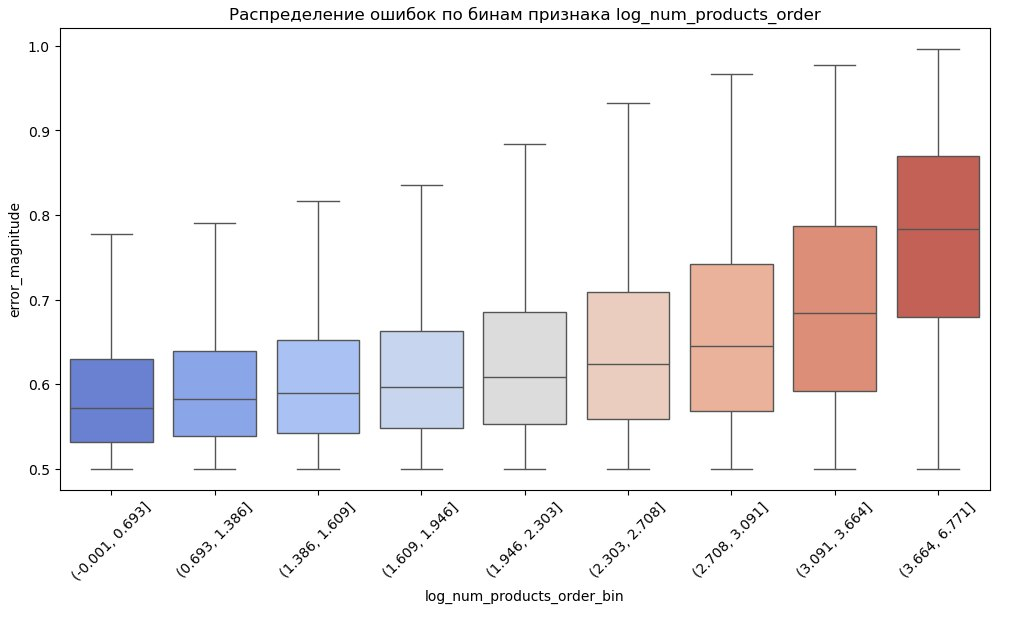

In [7]:
display(Image(url=f"data:image/jpg;base64,{box_plot_image}"))

Это пример красной строки во время работы с ними. Видно что на больших значениях она ошибается чаще

В своих исследованиях я дошел то того, что решил посмотреть распределение FN и FP веречин и попытаться кластеризовать их

In [ ]:
import umap
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import random
cluster_cols = random.sample(cols, 5)  
cluster_data = critical_zone[cluster_cols].fillna(0)

sampled_indices = cluster_data.sample(10000, random_state=42).index
sampled_data = cluster_data.loc[sampled_indices]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(sampled_data)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(scaled_data)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(umap_result)

plot_data = critical_zone.loc[sampled_indices].copy()
plot_data['umap_x'] = umap_result[:, 0]
plot_data['umap_y'] = umap_result[:, 1]
plot_data['cluster'] = clusters.astype(str)

fig = px.scatter(
    plot_data,
    x='umap_x',
    y='umap_y',
    color='error_type',
    symbol='cluster',
    hover_data=cluster_cols,
    title='Интерактивная визуализация ошибок FP/FN по кластерам',
    width=1000,
    height=600,
    color_discrete_map={'FP': '#FF7F0E', 'FN': '#1F77B4'}
)

fig.update_layout(
    legend_title_text='Тип ошибки / Кластер',
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    hovermode='closest'
)

hover_template = "<b>%{hovertext}</b><br><br>" + \
                "UMAP 1: %{x}<br>UMAP 2: %{y}<br>" + \
                "<br>".join([f"{col}: %{{customdata[{i}]:.2f}}" 
                           for i, col in enumerate(cluster_cols)])

fig.update_traces(hovertemplate=hover_template)

fig.show()

print("\nСтатистика по кластерам:")
cluster_stats = plot_data.groupby(['cluster', 'error_type'])[cluster_cols].mean()
display(cluster_stats)

print("\nРаспределение ошибок:")
error_dist = pd.crosstab(plot_data['cluster'], plot_data['error_type'], normalize='index')
display(error_dist.style.format('{:.1%}'))


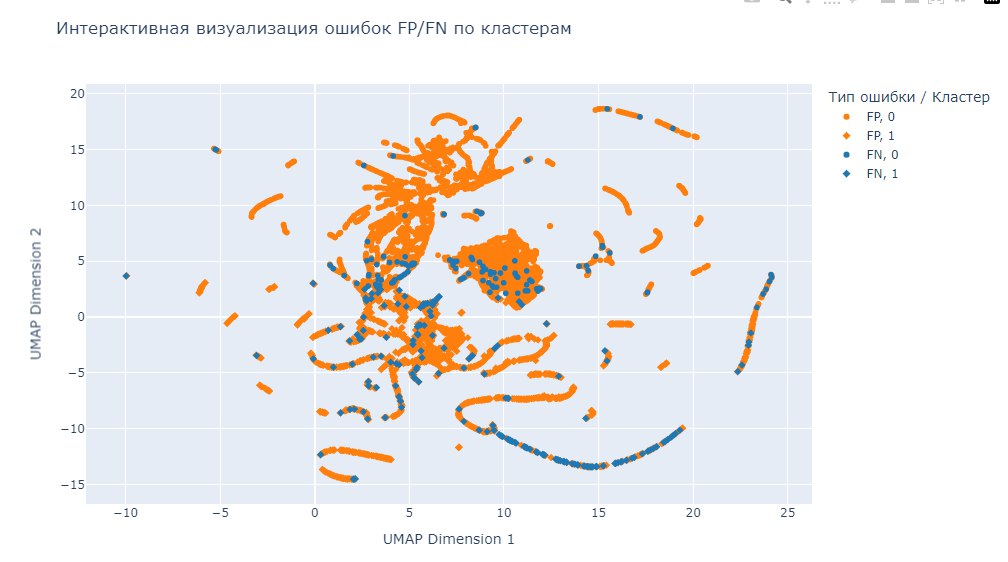

In [8]:
display(Image(url=f"data:image/jpg;base64,{FNFPCluster_image}"))

Здесь через Umap строй график ошибок, синие это 1, которые модель обозначила как 0 (те False Negative), а оранжевые наоборот. К сожалению нет никакой зависимости и четкий кластеров синих и оранжевых точек, синие просто рандомно раскиданы.

--------------------

# Понижение размерности

При решении задачи я много пользовался понижением размерности, например выше при анализе ошибок, а также для генерации самих признаков.

In [ ]:
def add_pca_columns( df: pd.DataFrame,  columns: list,  n_components: int = None, prefix: str = 'pca_', scale: bool = True):
    data = df[columns].copy()

    data[columns] = data[columns].replace([np.inf, -np.inf], np.nan)

    zero_fill_cols = [col for col in columns if col.startswith(('num_', 'sum_', 'max_', 'days_', 'log_', 'avg_', 'main_', 'search_', 'product_', 'recent_'))]
    zero_fill_cols_end = [col for col in columns if col.endswith(('_30d'))]
    time_fill_cols = [col for col in columns if col.endswith('_time')]
    
    data[zero_fill_cols] = data[zero_fill_cols].fillna(0)
    data[zero_fill_cols_end] = data[zero_fill_cols_end].fillna(0)
    data[time_fill_cols] = data[time_fill_cols].fillna(pd.Timestamp('2024-01-01 00:00:00'))
    print('Nans filled')
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(data)
    
    pca_columns = [f"{prefix}{i+1}" for i in range(pca_components.shape[1])]
    
    for i, col in enumerate(pca_columns):
        df[col] = pca_components[:, i]
    
    return df

Этот код добавляет в датасет колонки вектором РСА разложения. Особого эффекта это не дало, но и ресурсов не заняло. 

--------------------

# Кластеризация

Как я уже сказал в дневнике, мне кажется что сделать кластеризацию в привычном смысле невозможно, потому что модель не сможет определить, что слова кефир и молоко относятся к одной категории, ибо лексикографически у них нет ничего общего. 

Данные поисковых запросов выглядят вот так: 


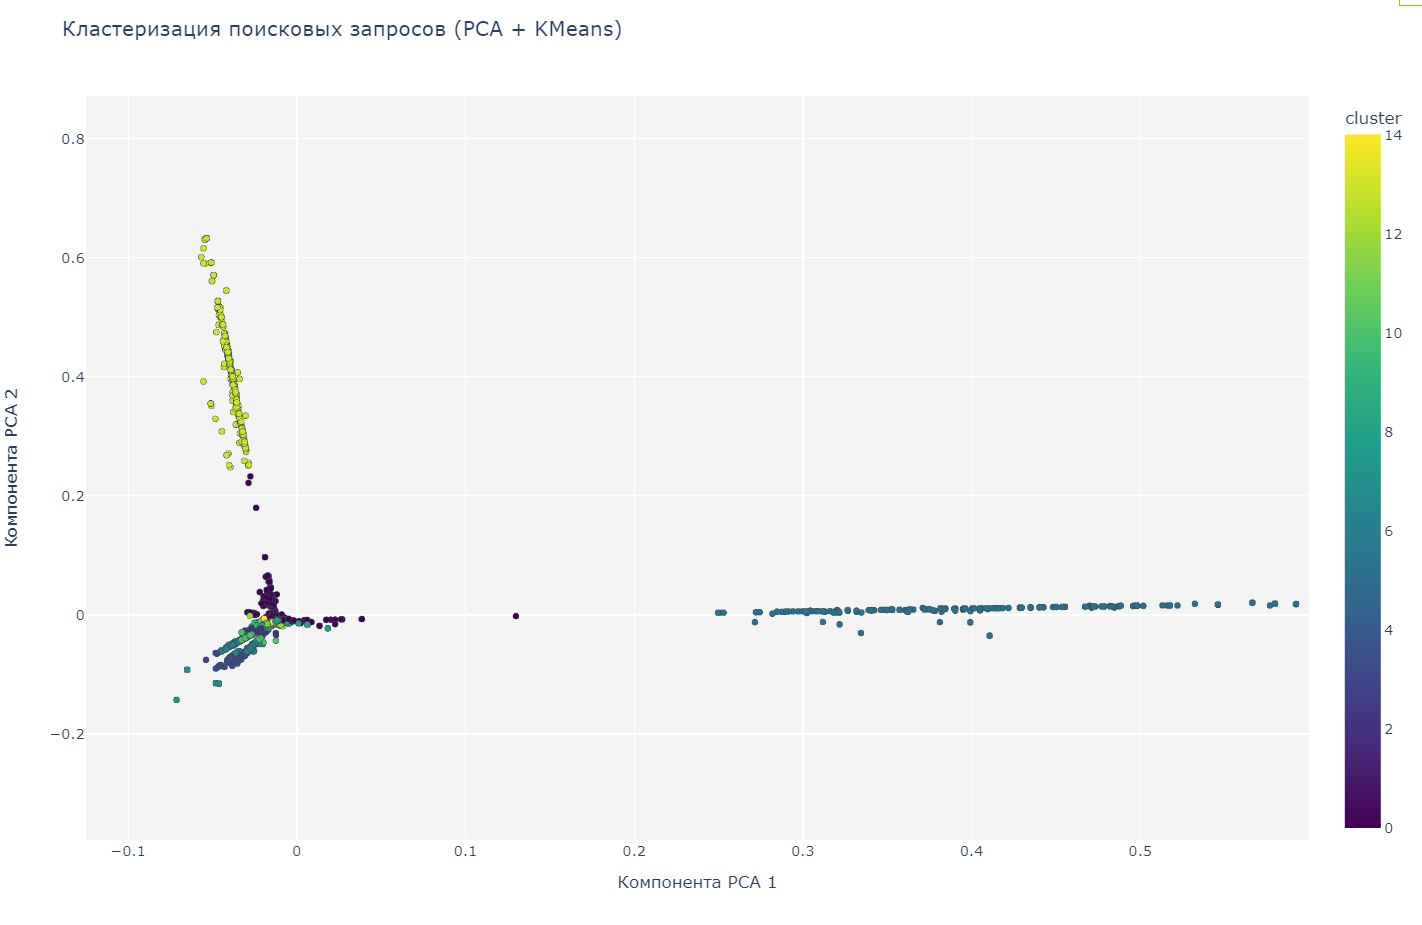

In [9]:
display(Image(url=f"data:image/jpg;base64,{clust_1_image}"))


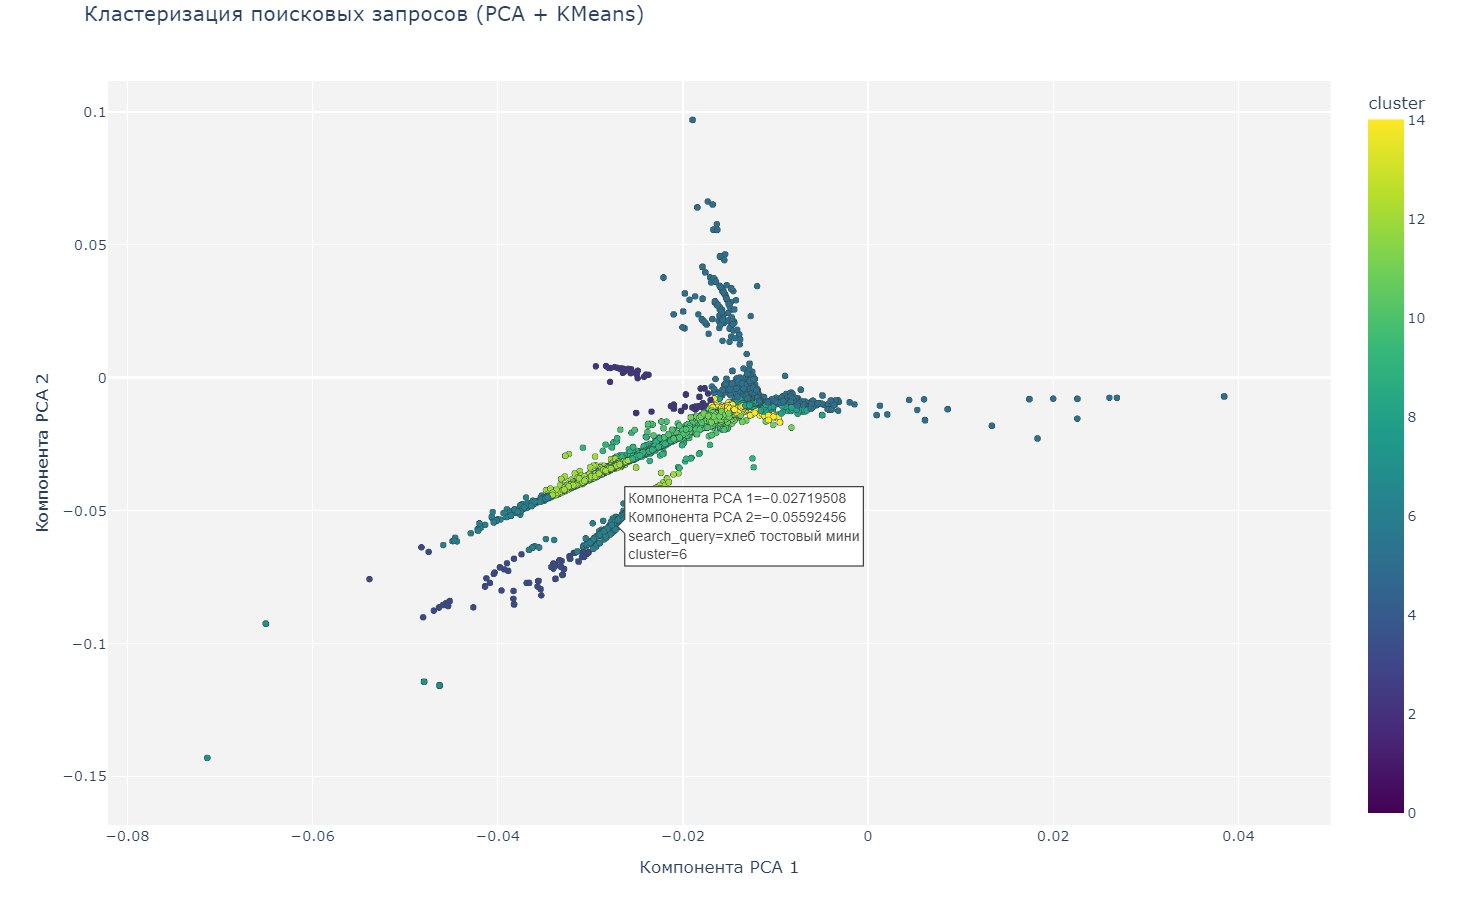

In [10]:
display(Image(url=f"data:image/jpg;base64,{clust_2_image}"))

На верхнем скрине видно две выраженеые полоси и какуюто кучу(они на нижнем скрине). Все группы имеют интересную лучевую структуру. Кажадя полоса это отдельная группа, содержащяя какое то ключевое слово. Как раз такое устройство аднных натолкнуло меня на мысль о полуавтоматической кластеризации. Это когда с бью все запросы на слова, запихиваю все в коллекцию и вывожу топ. Эти слова нужно в ручную определить в списки групп. Дальше остается только пропустить датасет через этот словарь из меток и ключевых слов и раздать запросам метки. Проблема такого подхода от части зависит от размера, 77кк запросов это много, я слов в них больше. И если слова типа "вода" и "хлеб" при разметке откидывают сразу по 1кк запросов, то слова типа "вешалка" всего 20_000, а дальше еще меньше. в общем за первый день я оставил 23кк запросо, а за 4 оставшихся сократил их количество до 6.5кк. Честно последний день кластеризации был лишним и скорее подпортил, потому что бездумное закидывание слов хоть в какую то категорию ухудшает их качество. 

Вот так можно определить самые популярные слова из еще не размеченых запросов:

In [ ]:
import pandas as pd
from collections import Counter

sh_topd_filtered = search_history[search_history['cluster'] == -1].copy()

all_words = []
for query in sh_topd_filtered['search_query']:
    words = query.split()
    all_words.extend(words)

unique_words = set(all_words)

word_counts = Counter(all_words)

sorted_word_counts = word_counts.most_common()

top_words = [word for word, count in sorted_word_counts]

print(f"Всего уникальных слов: {len(unique_words)}")
print("Топ самых частых слов:")
print(top_words[:150])

А вот что с ними делать. Сначала раскидываем по категориям, вы можете сами догадаться где какой класс)

In [ ]:
cluster_mapping = {
    1: ['пармалат', 'теос', 'nemoloko', 'имунеле', 'таорог', 'эконива', 'гхи', 'масле', 'савушкин',
        'monterra', 'ацидофилин', 'эскимо', 'маргарин', 'viola', 'яица', 'урбеч'],
    2: ['закуска', 'жевачка', 'чтпсы', 'rex', 'любятово', 'щербет', 'mirel', 'шоколад', 'баунти', 'наполеон',
        'читос', 'fitnesshock', 'shock', 'кето', 'аленка', 'чоко', 'фри', 'бабл', 'равиоли', 'роше', 'конфитюр',
        'kitkat', 'ferrero', 'марс', 'рафаэлло', 'бенто', 'скитлс', 'milky', 'merci', 'мерси', 'twix', 'подушечки',
        'панчо', 'пикник', 'solvie', 'веган', 'крупы', 'lindt', 'роял'],
    3: ['макаруны', 'кимчи', 'клетчатка', 'псиллиум', 'nordic', 'мистраль', 'увелка', 'биг', 'птитим', 'кус',
        'корнерсы', 'чиа', 'отруби', 'кускус', 'плов', 'ясно', 'травы', 'паэлья', 'yelli', 'удон'],
    4: ['абрикосы', 'архыз', 'халапеньо', 'смородина', 'черника', 'банка', 'помело', 'грейпфрут', 'мак', 'фундук',
       'бобы', 'каперсы', 'орешки', 'чука', 'лечо', 'сорбет', 'маринованные', 'хурма', 'облепиха', 'чери', 'слива',
       'трюфель', 'ржаной', 'оливье', 'романо', 'инжир', 'крахмал'],
    5: ['borjomi', 'energy', 'мажитэль', 'nescafe', 'tea', 'greenfield', 'lavazza', 'evervess', 'adrenaline', 'шампанское',
       'бокалы', 'актибио', 'пиву', 'блю', 'pepper', 'rich', 'bushido', 'burn', 'нарзан', 'швепс', 'дюшес', 'пепси',
       'lipton', 'новотерская', 'лёд', 'drip'],
    6: ['савоярди', 'эклер', 'пончики', 'гренки', 'слойка', 'брауни', 'лепешки', 'пирожки', 'безе', 'запеканка',
       'оладьи', 'пергамент', 'ватрушка', 'круасан', 'галеты', 'коржи', 'хачапури', 'край'],
    7: ['natura', 'маасдам', 'сиртаки', 'чечил', 'бри', 'альметте', 'халуми'],
    8: ['pi', 'дог', 'purina', 'one', 'лоток', 'миска', 'cat', 'роял'],
    9: ['тефтели', 'перекус', 'сибас', 'телятина', 'штрудель', 'окорок', 'докторская', 'язык', 'жареный', 'хинкали',
       'окраина', 'вязанка', 'шницель', 'дамплинги', 'крылья', 'сервелат', 'фуэт', 'заморозка', 'чевапчичи', 'hi',
       'буженина', 'гуляш', 'палтус', 'велком', 'панировка', 'балык', 'перепелка', 'черкизово', 'maggi', 'обед',
       'бульмени', 'манты', 'килька', 'крылышки', 'прошутто', 'сальчичон', 'состски'],
    10: ['папка', 'liebe', 'фломастеры', 'ваниш', 'мешок', 'синергетик', 'таз', 'жалюзи', 'сады', 'обои', 'фигурки',
        'маркер', 'лак', 'тазик', 'листы', 'шланг', 'брелок', 'кассеты', 'органайзер', 'полка', 'вернель', 'мебель',
        'кухонные', 'разделочная', 'мух', 'кухонный', 'бутылка', 'приготовления', 'пост', 'гладильная', 'тарелки',
        'корзина', 'бокс', 'расческа', 'термос', 'пемолюкс', 'спички', 'зажигалка', 'насос', 'ковер', 'очиститель',
        'ножи', 'блюда', 'труб', 'надувной', 'grass', 'пила', 'комод', 'садовая', 'история', 'засоров', 'тапки',
        'кольцо', 'тараканов', 'инструменты', 'фейри', 'вешалки', 'горшок', 'розетка', 'вешалка', 'крючки', 'азелит',
        'санокс', 'конверт', 'fairy', 'ручки', 'терка', 'сердечки', 'фумигатор', 'ушастый', 'веник', 'диск', 'чашка',
        'массажер', 'лопатка', 'ежедневник', 'насадка', 'коробки', 'розжиг', 'газовая', 'силит', 'персил', 'kix',
        'мешки', 'domestos', 'казан', 'туалет', 'простынь', 'bang', 'монитор'],
    11: ['lol', 'мама', 'kabrita', 'кубики', 'momi', 'baby', 'semper', 'кабрита', 'малютка', 'nutrilak', 'pampers',
        'беби', 'малоежка', 'gerber', 'коляска', 'merries', 'хот', 'комфорт', 'поп', 'similac', 'пазл', 'нянь',
        'lovular', 'горки', 'машинки', 'шар', 'домик', 'пазлы'],
    12: ['дождевик', 'nike'],
    13: ['ти', 'кашля', 'just', 'эвалар', 'ополаскиватель', 'термометр', 'снуп', 'полоски', 'хлоргексидин', 'солнышко',
        'пантенол', 'мирамистин', 'раствор', 'acuvue', 'bio', 'форте', 'терафлю', 'полисорб', 'прыщей', 'аквафор',
        'тонометр', 'градусник', 'смекта', 'эспумизан', 'ромашка', 'мелатонин', 'лекарства', 'доктор', 'стрепсилс',
        'лисички', 'таблетница', 'аптека'],
    14: ['heinz', 'тар', 'махеев', 'шрирача'],
    15: ['аккумуляторная', 'отпариватель', 'mio', 'алиса', 'станция', 'вафельница', 'роутер', 'яндекс', 'диффузор',
        'робот', 'автомобильный', 'фона', 'infinix', 'тостер', 'hdmi', 'аккумулятор', 'ирригатор', 'шуруповерт',
        'триммер', 'капучинатор', 'электронная', 'аппарат', 'монитор'],
    17: ['земля', 'дача'],
    19: ['green', 'dove', 'лепестки', 'чистая', 'лубрикант', 'пудра', 'серьги', 'карандаш', 'накладные', 'косметичка',
        'браслет', 'доя', 'ногти', 'линия', 'bioderma', 'nivea', 'dolce', 'head', 'ice', 'matrix', 'консилер',
        'анальная', 'спирт', 'holika', 'член', '18+', 'estel', 'rocher', 'пробка', 'mixit', 'vichy', 'pusy',
        'aravia'],
    20: ['табачные', 'авто', 'gillette', 'игры', 'автомобиль', 'дорожный', 'vaz', 'сигарета', 'фигурка'],
    21: ['korner', 'стевия', 'креатин', 'спорт', 'fit', 'мяч', 'fitnesshock', 'гантели', 'шейкер']
}

А дальше нужно пропустить через него датасет

In [ ]:
import re

for cluster_id, keywords in cluster_mapping.items():
    pattern = '|'.join(map(re.escape, keywords))
    search_history.loc[search_history['search_query'].str.contains(pattern, case=False, na=False), 'cluster'] = cluster_id

Такой обьем слов можно распределить где то за 5-6 часов и он убирает где то 3-4кк запросов. Как я уже сказал чем дальше, чем сложнее это делать, потому что каждое слово начинает представлять меньше поисковых запросов.

Удобство метода заключается в том, что точно также можно провести кластеризацию и продуктов, при этом не нужно создавать отдельных словарей, старые отлично подойдут.

----------------------------------------

# Ближайшие соседи

По моему мнению кнн в рамках данной задачи необнозначный метод. При анализе созданых им фичей они часто фигурируют среди сильно ошибающихся и при этом не супер важные. В некоторых случаях скор даже падает. Помимо этого их добавление занимает 2*20 минут, просто невыносимо. Для их создания я использовал фаис, вынес это все в отдельную функцию

In [ ]:
def add_knn_features_faiss(df_pd, features, n_neighbors=5, use_gpu=True):
    df = df_pd.copy()
    
    # Заполнение пропусков
    zero_fill_cols = [col for col in features if col.startswith(('num_', 'sum_', 'max_', 'days_'))]
    time_fill_cols = [col for col in features if col.endswith('_time')]
    
    df[zero_fill_cols] = df[zero_fill_cols].fillna(0)
    df[time_fill_cols] = df[time_fill_cols].fillna(pd.Timestamp('2024-01-01 00:00:00'))
    print('Nans filled')
    
    minmax_scaler = MinMaxScaler()
    df[features] = minmax_scaler.fit_transform(df[features])
    print('Data scaled')
    
    # FAISS
    d = len(features)
    data = df[features].values.astype('float32')
    
    if use_gpu and faiss.get_num_gpus() > 0:
        res = faiss.StandardGpuResources()
        index = faiss.GpuIndexFlatL2(res, d)
        print('Using GPU')
    else:
        index = faiss.IndexFlatL2(d)
        print('Using CPU')
    
    index.add(data)
    print('FAISS index built')
    
    # Поиск ближайших соседей
    distances, indices = index.search(data, n_neighbors)
    print('KNN search done')
    
    # Создание новых прищзакнв
    knn_features = {}
    df['knn_distance_mean'] = distances.mean(axis=1)
    df['knn_distance_max'] = distances.max(axis=1)
    df['knn_distance_min'] = distances.min(axis=1)
    df['knn_distance_std'] = distances.std(axis=1)
    df['knn_distance_range'] = df['knn_distance_max'] - df['knn_distance_min']
    df['knn_local_density'] = 1 / (df['knn_distance_mean'] + 1e-6)  # Локальная плотность



    if 'days_since_first_order' in features and 'days_since_last_order' in features:
        df['knn_recency_ratio'] = df['days_since_last_order'] / (df['days_since_first_order'] + 1)
        knn_features['knn_activity_decay'] = df['days_since_last_order'].values - df['days_since_last_order'].values[indices].mean(axis=1)
    
    # корзина и активность
    if 'sum_discount_price_to_cart' in features and 'num_products_click' in features:
        knn_features['knn_price_per_product'] = df['sum_discount_price_to_cart'] / (df['num_products_click'] + 1e-6)
    
    if 'cart_add_ratio_30d' in features:
        knn_features['knn_cart_consistency'] = df['cart_add_ratio_30d'] / (df['cart_add_ratio_30d'].values[indices].mean(axis=1) + 1e-6)
    
    # кластеризация
    if 'main_search_cluster' in features:
        knn_cluster_mode = stats.mode(df['main_search_cluster'].values[indices], axis=1)[0].ravel()
        df['knn_cluster_outlier'] = (df['main_search_cluster'] != knn_cluster_mode).astype(int)
    
    if 'search_cluster_stability' in features and 'product_cluster_stability' in features:
        knn_features['knn_cluster_stability_diff'] = df['product_cluster_stability'] - df['search_cluster_stability']
    
    # 5. активность
    if 'active_days_30d' in features:
        df['knn_activity_consistency'] = df['active_days_30d'] / 30
    
    if 'unique_clusters_30d' in features:
        knn_features['knn_cluster_exploration'] = df['unique_clusters_30d'] / (df['unique_clusters_30d'].values[indices].mean(axis=1) + 1e-6)
    
    weights = 1 / (distances + 1e-6)
    for feature in features:
        knn_values = df[feature].values[indices]
        
        # Обычные статистики
        knn_features[f'knn_{feature}_mean'] = knn_values.mean(axis=1)
        knn_features[f'knn_{feature}_max'] = knn_values.max(axis=1)
        knn_features[f'knn_{feature}_min'] = knn_values.min(axis=1)
        knn_features[f'knn_{feature}_std'] = knn_values.std(axis=1)
        knn_features[f'knn_{feature}_median'] = np.median(knn_values, axis=1)
        knn_features[f'knn_{feature}_sum'] = knn_values.sum(axis=1)
        knn_features[f'knn_{feature}_range'] = knn_features[f'knn_{feature}_max'] - knn_features[f'knn_{feature}_min']
        
        # Взвешенные статистики
        weighted_mean = np.sum(weights * knn_values, axis=1) / np.sum(weights, axis=1)
        knn_features[f'knn_{feature}_weighted_mean'] = weighted_mean
    
    if 'sum_discount_price_to_cart' in features and 'active_days_30d' in features:
        high_value_mask = (df['sum_discount_price_to_cart'] > knn_features['knn_sum_discount_price_to_cart_mean']) & \
                         (df['active_days_30d'] > knn_features['knn_active_days_30d_mean'])
        df['knn_high_value_activity'] = high_value_mask.astype(int)
    
    if 'product_cluster_stability' in features and 'active_days_30d' in features:
        stable_inactive_mask = (df['product_cluster_stability'] > knn_features['knn_product_cluster_stability_mean']) & \
                              (df['active_days_30d'] < knn_features['knn_active_days_30d_mean'])
        df['knn_stable_but_inactive'] = stable_inactive_mask.astype(int)

    
    for key, value in knn_features.items():
        df[key] = value
    
    print('KNN features created')
    return df

Все стандартно, заполняем пропуски, скейлим, находим соседей и делаем агрегаты. Применть функцию нужно в самом конце перед обучением, что бы можно было в качестве knn_cols передать любые агрегаты. 

Вообще кнн признаки действительно важны, многие из них в топе, это видно на одном из старых скринов ниже, но из-за того, что их построение достаточно долгое я в итоге от них практически отказался


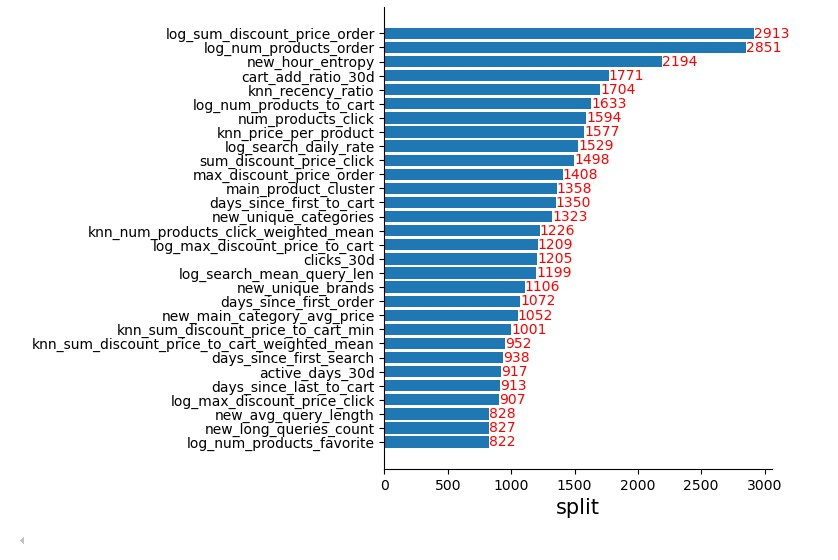

In [11]:
display(Image(url=f"data:image/jpg;base64,{knn_ex_image}"))

-------------------------------------------------------

# Тюнинг гиперпараметров бустинга

Применение оптюны в данной задаче интересное, но не полезное. По моему опыту могу сказать, что модель ужасно быстро переобучается, подбирать параметры вообше нет особо смысла, даже малейшее изменение max_depth=7 и lr=0.01 приводит либо к ухудшению, либо к переобучению. Разве что можно попробовать поставить значение +- 0.002 от указаного выше. 

Ниже пример оптюны для lgb

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
from local_utils import *

add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(add_new_df_pd, val_size=0.25, random_state=50)

add_new_cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})


def objective(trial, X_tr, y_tr, X_val, y_val):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 42,
        
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 75),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
    }
    
    model = lgb.LGBMClassifier(
        n_estimators=1000,
        verbosity=-1,
        **params
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=60, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    
    return auc

X_tr = lgb_tr[add_new_cols]
y_tr = lgb_tr['target']
X_val = lgb_val[add_new_cols]
y_val = lgb_val['target']

assert not y_tr.isna().any(), "Train target contains NaN"
assert not y_val.isna().any(), "Validation target contains NaN"

study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective(trial, X_tr, y_tr, X_val, y_val),
    n_trials=50,
    timeout=600,  # 1 час
    show_progress_bar=True
)

print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'random_state': 42,
    'verbosity': 1,
    'n_estimators': 2000,
    **study.best_params
}

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(
    pd.concat([X_tr, X_val]),
    pd.concat([y_tr, y_val]),
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=60),
        lgb.log_evaluation(period=50)
    ]
)

-----------------------------------------

Итоговый скор: 0.8263. Спасибо за лучшее дз за все вермя обучения. 